Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Similarity Supervised Learning Hello World

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/supervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/supervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

## Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to train a `SimilarityModel()` on a fraction of the MNIST classes, and yet the model is able to index and retrieve similar looking images for all MNIST classes. 

You are going to learn about the main features offered by the `SimilarityModel()` and will:

 1. `train()` a similarity model on a sub-set of the 10 MNIST classes that will learn how to project digits within a cosine space

 2. `index()` a few examples of each of the 10 classes present in the train dataset (e.g 10 images per classes) to make them searchable

 3. `lookup()` a few test images to check that the trained model, despite having only a few examples of seen and unseen classes in it's index, is able to efficiently retrieve similar looking examples for all classes.

 4. `calibrate()` the model to estimate what is the best distance theshold to separate matching elements from elements belonging to other classes.

 5. `match()` the test dataset to evaluate how well the calibrated model works for classification purpose.

## Things to try 

Along the way you can try the following things to improve the model performance:
- Adding more "seen" classes at training time.
- Use a larger embedding by increasing the size of the output.
- Add data augmentation pre-processing layers to the model.
- Include more examples in the index to give the models more points to choose from.
- Try a more challenging dataset, such as Fashion MNIST.

In [2]:
import numpy as np
from tabulate import tabulate
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [ ]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [5]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.layers import MetricEmbedding # row wise L2 norm
from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
from tensorflow_similarity.models import SimilarityModel # TF model with additional features
from tensorflow_similarity.samplers import MultiShotMemorySampler  # sample data 
from tensorflow_similarity.samplers import select_examples  # select n example per class
from tensorflow_similarity.visualization import viz_neigbors_imgs  # neigboors vizualisation
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [ ]:
tfsim.utils.tf_cap_memory()

In [7]:
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.6.0
TensorFlow Similarity 0.14


# Data preparation

We are going to load the MNIST dataset and restrict our training data to **only N of the 10 classes** (6 by default) to showcase how the model is able to find similar examples from classes unseen during training. The model's ability to generalize the matching to unseen classes, without retraining, is one of the main reason you would want to use metric learning.


**WARNING**: Tensorflow similarity expects `y_train` to be an IntTensor containing the class ids for each example instead of the standard categorical encoding traditionally used for multi-class classification.

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

For a similarity model to learn efficiently, each batch must contains at least 2 examples of each class.

To make this easy, tf_similarity offers `Samplers()` that enable you to set both the number of classes and the minimum number of examples of each class per batch. Here we are creating a `MultiShotMemorySampler()` which allows you to sample an in-memory dataset and provides multiple examples per class.

TensorFlow Similarity provides various samplers to accomodate different requirements, including a `SingleShotMemorySampler()` for single-shot learning, a `TFDatasetMultiShotMemorySampler()` that integrate directly with the TensorFlow datasets catalogue, and a `TFRecordDatasetSampler()` that allows you to sample from very large datasets stored on disk as TFRecords shards.

In [9]:
CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
NUM_CLASSES = 6  #@param {type: "slider", min: 1, max: 10}
CLASSES_PER_BATCH = NUM_CLASSES
EXAMPLES_PER_CLASS = 6 #@param {type:"integer"}
STEPS_PER_EPOCH = 1000 #@param {type:"integer"}

sampler = MultiShotMemorySampler(x_train, y_train, 
                                 classes_per_batch=CLASSES_PER_BATCH, 
                                 examples_per_class_per_batch=EXAMPLES_PER_CLASS,
                                 class_list=CLASSES[:NUM_CLASSES], # Only use the first 6 classes for training.
                                 steps_per_epoch=STEPS_PER_EPOCH)


The initial batch size is 36 (6 classes * 6 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/6 [00:00<?, ?it/s]

gather examples:   0%|          | 0/36963 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/36963 [00:00<?, ?it/s]

# Model setup

## Model definition

`SimilarityModel()` models extend `tensorflow.keras.model.Model` with additional features and functionality that allow you to index and search for similar looking examples.

As visible in the model definition below, similarity models output a 64 dimensional float embedding using the `MetricEmbedding()` layers. This layer is a Dense layer with L2 normalization. Thanks to the loss, the model learns to minimize the distance between similar examples and maximize the distance between dissimilar examples. As a result, the distance between examples in the embedding space is meaningful; the smaller the distance the more similar the examples are. 

Being able to use a distance as a meaningful proxy for how similar two examples are, is what enables the fast ANN (aproximate nearest neighbor) search. Using a sub-linear ANN search instead of a standard quadratic NN search is what allows deep similarity search to scale to millions of items. The built in memory index used in this notebook scales to a million indexed examples very easily... if you have enough RAM :)

In [27]:
def get_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.experimental.preprocessing.Rescaling(1/255)(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = MetricEmbedding(64)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)   

## Loss definition

Overall what makes Metric losses different from tradional losses is that:
- **They expect different inputs.** Instead of having the prediction equal the true values, they expect embeddings as `y_preds` and the id (as an int32) of the class as `y_true`. 
- **They require a distance.** You need to specify which `distance` function to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.

In this example we are using the `MultiSimilarityLoss()`. This loss takes a weighted combination of all valid positive and negative pairs, making it one of the best loss that you can use for similarity training.

In [11]:
distance = 'cosine' #@param ["cosine", "L2", "L1"]{allow-input: false}
loss = MultiSimilarityLoss(distance=distance)

## Compilation

Tensorflow similarity use an extended `compile()` method that allows you to optionally specify `distance_metrics` (metrics that are computed over the distance between the embeddings), and the distance to use for the indexer.

By default the `compile()` method tries to infer what type of distance you are using by looking at the fist loss specified. If you use multiple losses, and the distance loss is not the first one, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [12]:
LR = 0.0001  #@param {type:"number"}
model = get_model()
model.compile(optimizer=Adam(LR), loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


# Training

Similarity models are trained like normal models. 

**NOTE**: don't expect the validation loss to decrease too much here because we only use a subset of the classes within the train data but include all classes in the validation data.

In [13]:
EPOCHS = 10 #@param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/10


2021-10-03 23:17:33.463021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-03 23:17:35.867684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1000/1000 [==============================] - 11s 7ms/step - loss: 1.6766 - val_loss: 1.4704
Warmup complete
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 1.2830 - val_loss: 1.4341
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0712 - val_loss: 1.4362
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9273 - val_loss: 1.4414
Epoch 5/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.8250 - val_loss: 1.4287
Epoch 6/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7271 - val_loss: 1.4117
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6712 - val_loss: 1.3930
Epoch 8/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5565 - val_loss: 1.3576
Epoch 9/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5186 - val_loss: 1.4290
Epoch 10/10
1000/1000 [==============================] - 7s 7ms/step - loss:

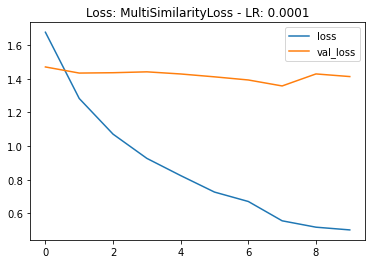

In [14]:
# expect loss: 0.014 / val_loss: 1.3
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(f'Loss: {loss.name} - LR: {LR}')
plt.show()

## Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position within the learned metric space, we need a way to find which known example(s) are the closest to determine the class of the query example (aka nearest neighboors classication).

To do so, **we are creating an index of known examples from all the classes present in the dataset**. We do this by taking a total of **200 examples from the train dataset which amount to 20 examples per class** and we use the `index()` method of the model to build the index.

we store the images (x_index) as data in the index `(data=x_index)` so that we can display them later. Here the images are small so its not an issue but in general, be careful while storing a lot of data in the index to avoid blewing up your memory. You might consider using a different `Store()` backend if you have to store and serve very large indexes.

Indexing more examples per class will help increase the accuracy/generalization, as having more variations improves the classifier "knowledge" of what variations to expect. 

Reseting the index is not needed for the fist run; however we always calling it to ensure we start the evaluation with a clean index in case of a partial re-run.

In [15]:
x_index, y_index = select_examples(x_train, y_train, CLASSES, 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/200 [00:00<?, ?it/s]

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


# Querying

To "classify" examples, we need to lookup their *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

Here we going to query a single random example for each class from the test dataset using `select_examples()` and then find their nearest neighboors using the `lookup()` function.

**NOTE** By default the classes 8, 5, 0, and 4 were not seen during training, but we still get reasonable matches as visible in the image below. 

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

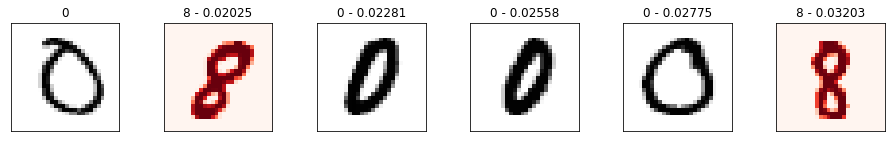

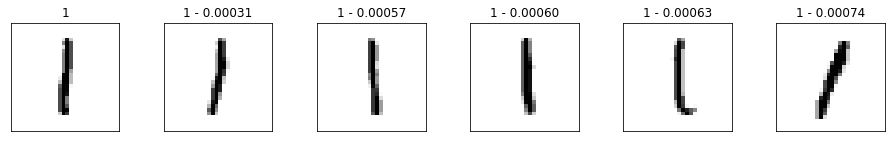

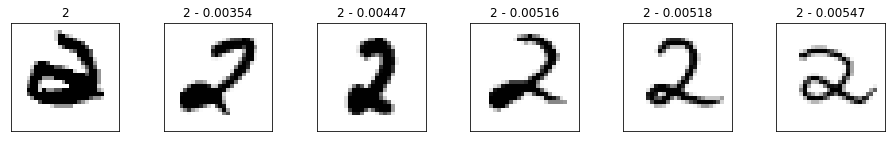

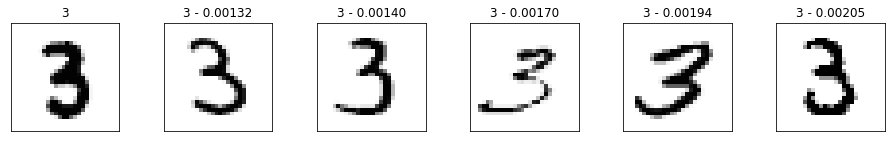

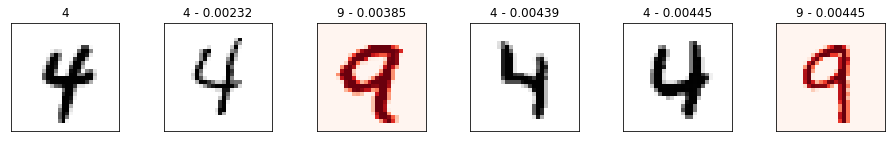

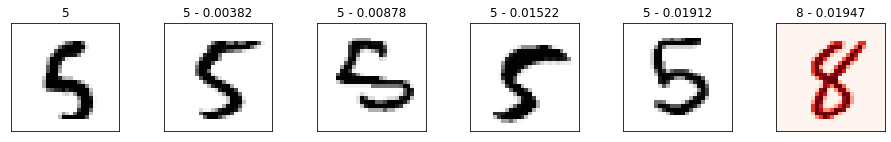

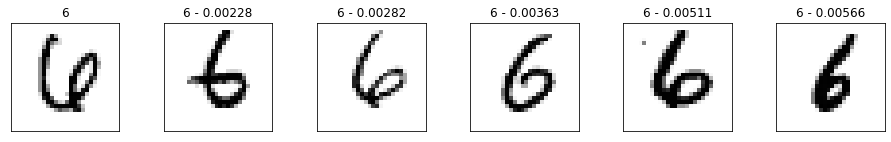

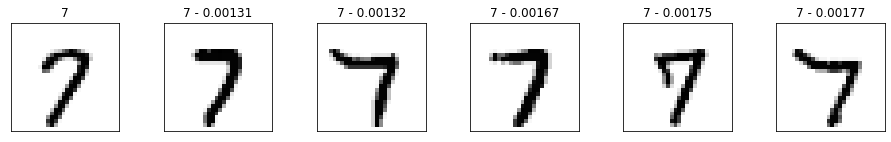

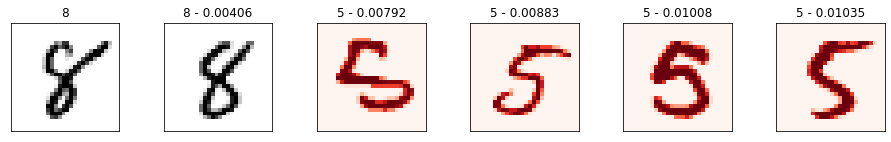

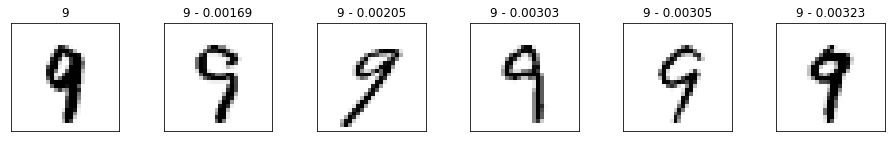

In [16]:
# re-run to test on other examples
num_neighboors = 5

# select
x_display, y_display = select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighboors)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      fig_size=(16, 2), cmap='Greys')

## Matching

To be able to tell if an example matches a given class, we first need to `calibrate()` the model to find the optimal cut point. This cut point is the maximum distance below which returned neighbors are of the same class. Increasing the threshold improves the recall at the expense of the precision.

By default, the calibration uses the F1Score classification metric to optimally balance out the precsion and recalll; however, you can speficy your own target and change the calibration metric to better suite your usecase.

In [17]:
num_calibration_samples = 1000 #@param {type:"integer"}
calibration = model.calibrate(
    x_train[:num_calibration_samples], 
    y_train[:num_calibration_samples], 
    extra_metrics=['precision', 'recall', 'binary_accuracy'], 
    verbose=1
)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/990 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy        f1
-------  -------  ----------  -----------  --------  -----------------  --------
optimal     0.96    0.053153        0.923         1              0.923  0.959958


## Metrics Ploting

Let's plot the performance metrics to see how they evolve as the distance threshold increases. 

We clearly see an inflection point where the precision and recall intersect, however, this is not the `optimal_cutpoint` because the recall continues to increase faster than the precision decreases. Different usecases will have different performance profiles, which why each model needs to be calibrated.

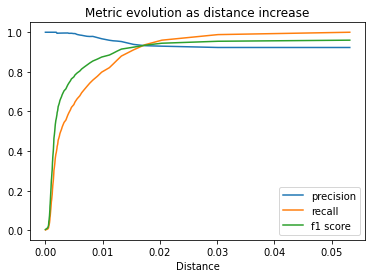

In [18]:
fig, ax = plt.subplots()
x = calibration.thresholds['distance']
ax.plot(x, calibration.thresholds['precision'], label='precision')
ax.plot(x, calibration.thresholds['recall'], label='recall')
ax.plot(x, calibration.thresholds['f1'], label='f1 score')
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel('Distance')
plt.show()

### Precision/Recall curve

We can see in the precision/recall curve below, that the curve is not smooth.
This is because the recall can improve independently of the precision causing a 
seesaw pattern.

Additionally, the model does extremly well on known classes and less well on 
the unseen ones, which contributes to the flat curve at the begining followed 
by a sharp decline as the distance threshold increases and 
examples are further away from the indexed examples.

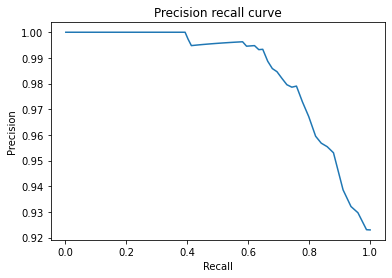

In [19]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds['recall'], calibration.thresholds['precision'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

## Matching

The purpose of `match()` is to allow you to use your similarity models to make 
classification predictions. It accomplishes this by finding the nearest neigbors
for a set of query examples and returning an infered label based on neighbors 
labels and the matching strategy used (MatchNearest by default).

Note: unlike traditional models, the  `match()` method potentially returns -1 
when there are no indexed examples below the cutpoint threshold. The -1 class
should be treated as "unknown".

## Matching in practice
Let's now match a 10 examples to see how you can use the model `match()` method 
in practice. 

In [20]:
num_matches = 10 #@param {type:"integer"}

matches = model.match(x_test[:num_matches], cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'Expected', 'Correct']))

  Predicted    Expected    Correct
-----------  ----------  ---------
          7           7          1
          2           2          1
          1           1          1
          0           0          1
          4           4          1
          1           1          1
          4           4          1
          9           9          1
          0           5          0
          9           9          1


## confusion matrix
Now that we have a better sense of what the match() method does, let's scale up 
to a few thousand samples per class and evaluate how good our model is at 
predicting the correct classes.

As expected, while the model prediction performance is very good, its not 
competitive with a classification model. However this lower accuracy comes with 
the unique advantage that the model is able to classify classes 
that were not seen during training.


**NOTE** `tf.math.confusion_matrix` doesn't support negative classes, so we are going to use **class 10 as our unknown class**. As mentioned earlier, unknown examples are 
any testing example for which the closest neighbor distance is greater than the cutpoint threshold.

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10000 [00:00<?, ?it/s]

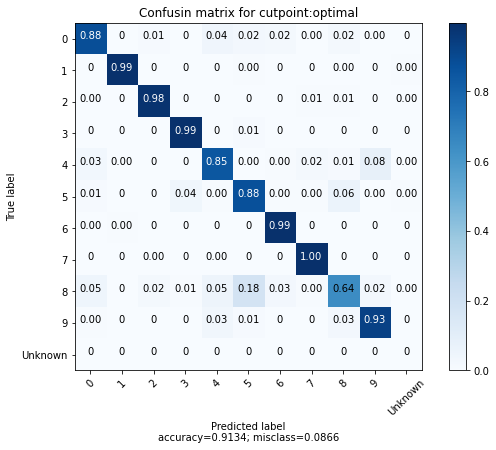

In [21]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = ["0", "1",  "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]
num_examples_per_class = 1000
cutpoint = 'optimal'

x_confusion, y_confusion = select_examples(x_test, y_test, CLASSES, num_examples_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
confusion_matrix(matches, y_confusion, labels=labels, title='Confusin matrix for cutpoint:%s' % cutpoint)

# Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [22]:
model.index_summary()

[Info]
------------------  ------
distance            cosine
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          200
calibrated          True
calibration_metric  f1
embedding_output
------------------  ------



[Performance]
-----------  ---------------
num lookups  11020
min              1.06409e-05
max              1.06409e-05
avg              1.06409e-05
median           1.06409e-05
stddev           0
-----------  ---------------


# Saving and reloading
Saving and reloading the model works as you would expected: 

- `model.save(path)`: save the model and the index on disk (`save_index=False`). By default the index is compressed - can be disabled by setting `compressed=False`

- `model = tf.keras.model.load_model(path)` reload the model. To reload the index you then need to call model.load_index(path)

- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index indenpendly of saving/loading a model if need to be


## Saving

In [ ]:
# save the model and the index
save_path = 'models/hello_world' #@param {type:"string"}
model.save(save_path)

## Reloading

In [24]:
# reload the model
reloaded_model = load_model(save_path)
# reload the index
reloaded_model.load_index(save_path)

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
loaded 200 records from models/hello_world/index
Loading search index
Loading calibration data


In [25]:
#check the index is back
reloaded_model.index_summary()

[Info]
------------------  ------
distance            cosine
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          200
calibrated          True
calibration_metric  f1
embedding_output
------------------  ------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


## Query reloaded model
Querying the reloaded model with its reload index works as expected

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

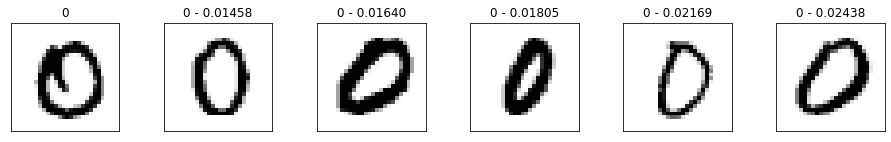

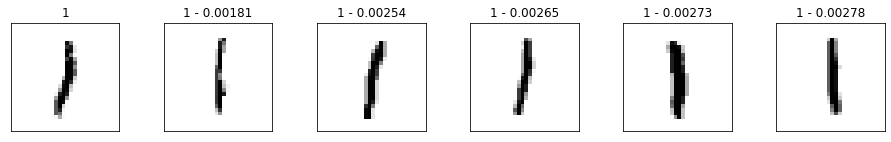

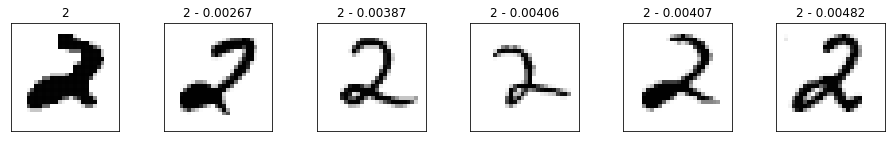

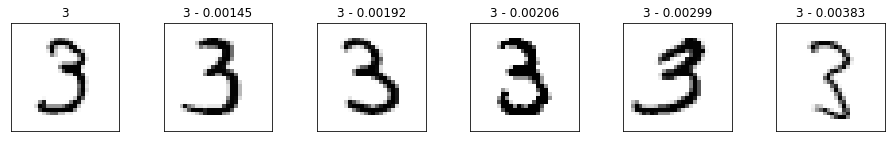

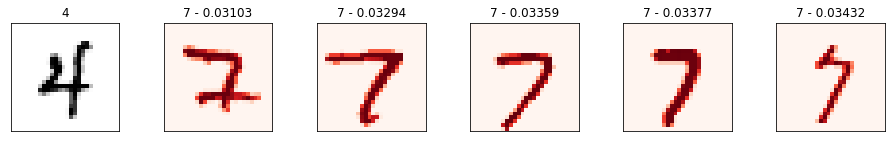

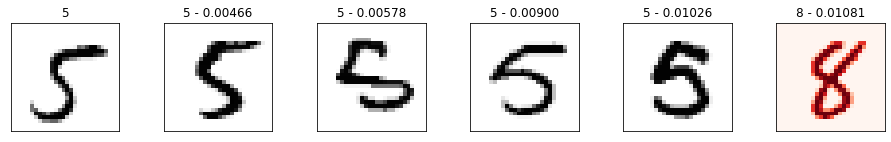

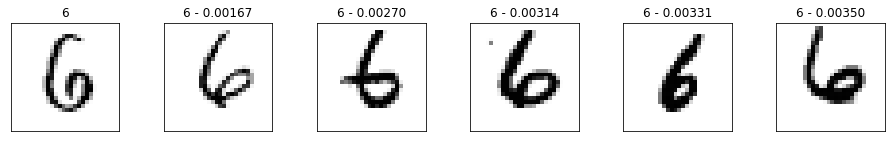

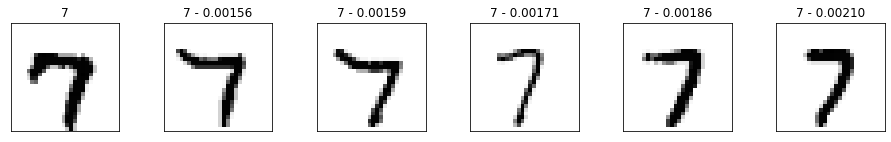

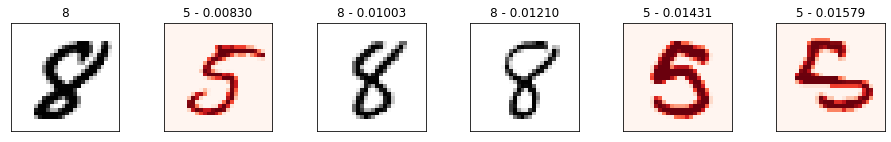

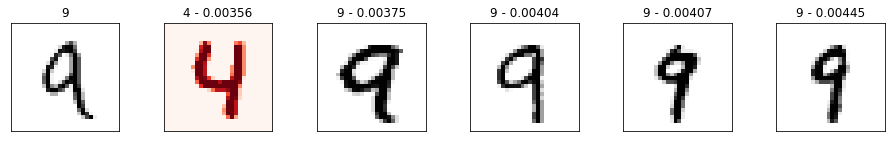

In [26]:
# re-run to test on other examples
num_neighboors = 5

# select
x_display, y_display = select_examples(x_test, y_test, CLASSES, 1)

# lookup the nearest neighbors
nns = model.lookup(x_display, k=num_neighboors)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      fig_size=(16, 2), cmap='Greys')

Thanks you for following this tutorial till the end. If you are interested in learning about TensorFlow Similarity advanced features, you can checkout our other notebooks.